# Assessment

Objetivo de la prueba


En este caso, se quiere pronosticar la demanda de un producto para una semana
determinada, en una tienda especial. El conjunto de datos que recibe consta de 8 semanas
de transacciones de ventas en México.
Cada semana, hay camiones de reparto que entregan productos a los vendedores. Cada
transacción consiste en ventas y devoluciones. Las devoluciones son los productos que no
se han vendido y caducado.
La demanda de un producto en una semana determinada se define como las ventas de esta
semana restado por el retorno de la próxima semana.

Requisitos

1. Intentar desarrollar la prueba en Python / R / SQL, o el programa que se
le facilite.
2. Comparte el documento con las respuestas, incluye una breve explicación
de tus resultados.
3. Comparta su código para revisarlo en detalle.

Entregables
1. Justifica la elección del algoritmo que utilizaste.
2. Graficar una serie de tiempo para una determinada combinación
producto-cliente-agencia.
3. Agregue varias métricas de su elección para mostrar la solidez del algoritmo.
4. Definir una muestra de clientes que represente a una agencia específica
(Especifique cuál agencia y cuáles fueron sus criterios de selección y metodología
aplicada).
5. Prediga la semana 9 para los 3 productos más vendidos en la muestra de su cliente.
6. Haz un dibujo de diagrama de flujo que mapee todos los pasos de tu algoritmo
usado.

En caso de no terminar en la fecha prevista, enviar lo realizado.


Cosas a tener en cuenta:
1. Puede haber productos en el conjunto de prueba que no existen en el conjunto
de entrenamiento. Este es el comportamiento de los datos de inventario, ya que
hay nuevos productos que se venden todo el tiempo. Tu modelo debería ser
capaz de acomodar esto.
2. Hay Cliente_ID duplicados en cliente_tabla, lo que significa un Cliente_ID. Puede
tener múltiples NombreCliente que son muy similares. Esto se debe al
NombreCliente ser ruidoso y no estandarizado en los datos sin procesar, por lo
que depende de usted decidir cómo limpiar y utilizar esta información.
3. La demanda ajustada (Demanda_uni_equil) siempre es >= 0 ya que la demanda
debería ser un 0 o un valor positivo. La razón que Venta_uni_hoy -
Dev_uni_proxima a veces tiene valores negativos es que el los registros de
devoluciones a veces se prolongan durante algunas semanas.

![Moelo relacional](Untitled.png)



# Key concepts

Descripciones de archivos
1. cliente_tabla.csv: nombres de clientes (se pueden unir con train/test en
Cliente_ID)
2. producto_tabla.csv: nombres de productos (se pueden unir con train/test en
Producto_ID)
3. estados_state.csv: ciudad y estado (se puede unir con train/test en
Agencia_ID) 

Campos de información
1. Semana — Número de semana (de jueves a miércoles)
2. Agencia_ID: ID del depósito de ventas
3. Canal_ID: ID del canal de ventas
4. Ruta_SAK: ID de ruta (Varias rutas = Depósito de ventas)
5. Cliente_ID: identificación del cliente
6. NombreCliente — Nombre del cliente
7. Producto_ID — Identificación del producto
8. NombreProducto — Nombre del producto
9. Venta_uni_hoy: unidad de ventas de esta semana (entero)
10. Venta_hoy — Ventas esta semana (unidad: pesos)
11. Dev_uni_proxima: devuelve la unidad la próxima semana
(entero)
12. Dev_proxima — Vuelve la próxima semana (unidad: pesos)
13. **Demanda_uni_equil — Demanda ajustada (entero) (Este es el objetivo que predecir)**

# Libreries definition

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


# Data import & data cleaning

In [2]:
data_cliente = pd.read_csv("cliente_tabla.csv")
data_cliente.shape

(935362, 2)

At fist sight this is clearly a catalog table for all customers:

In [3]:
data_cliente.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


Also, there's no missing data.

In [4]:
data_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935362 entries, 0 to 935361
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Cliente_ID     935362 non-null  int64 
 1   NombreCliente  935362 non-null  object
dtypes: int64(1), object(1)
memory usage: 14.3+ MB


In [5]:
print(f"Duplicated rows: {data_cliente.duplicated().sum()}")

Duplicated rows: 0


In [6]:
data_producto = pd.read_csv("Producto_tabla.csv")
data_producto.shape

(2592, 2)

Same for the product data which is a catalog of all existing products. Fortuately there's no missing data.

In [7]:
data_producto.head()

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


In [8]:
data_producto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Producto_ID     2592 non-null   int64 
 1   NombreProducto  2592 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.6+ KB


In [9]:
print(f"Duplicated rows: {data_producto.duplicated().sum()}")

Duplicated rows: 0


In [10]:
data_estados = pd.read_csv("estados.csv", encoding='ISO-8859-1')
data_estados.shape

(41, 3)

The "estados.csv" file is another catalog. This time is a catalog of towns and states. There is an unnamed column that I'm not sure if it's an Id or not. I'll keep it for now. 

In [11]:
data_estados.head()

,Unnamed: 0,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


By mistake the first column is not correctly named. Let's fix it. Also, let's set the Agencia_ID as int64.

In [12]:
correct_names = {"Unnamed: 0": "Agencia_ID", "Town": "Town", "State" : "State"}
data_estados = data_estados.rename(columns = correct_names)
data_estados["Agencia_ID"] = data_estados["Agencia_ID"].astype('int64') 
data_estados.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [13]:
data_estados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Agencia_ID  41 non-null     int64 
 1   Town        41 non-null     object
 2   State       41 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


In [14]:
print(f"Duplicated rows: {data_estados.duplicated().sum()}")

Duplicated rows: 0


In [15]:
data_candidate = pd.read_csv("dfcandidate.csv")
data_candidate.shape

(7974418, 11)

In [16]:
data_candidate.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [17]:
data_candidate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7974418 entries, 0 to 7974417
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Semana             int64  
 1   Agencia_ID         int64  
 2   Canal_ID           int64  
 3   Ruta_SAK           int64  
 4   Cliente_ID         int64  
 5   Producto_ID        int64  
 6   Venta_uni_hoy      int64  
 7   Venta_hoy          float64
 8   Dev_uni_proxima    int64  
 9   Dev_proxima        float64
 10  Demanda_uni_equil  int64  
dtypes: float64(2), int64(9)
memory usage: 669.2 MB


In [18]:
print(f"Duplicated rows: {data_candidate.duplicated().sum()}")

Duplicated rows: 0


In [19]:
data_test = pd.read_csv("dftest.csv")
data_test.shape

(1328750, 6)

In [20]:
data_test.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,9,1110,7,3301,15766,1212
1,9,1110,7,3301,15766,1238
2,9,1110,7,3301,15766,1240
3,9,1110,7,3301,15766,1242
4,9,1110,7,3301,15766,1250


In [21]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328750 entries, 0 to 1328749
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Semana       1328750 non-null  int64
 1   Agencia_ID   1328750 non-null  int64
 2   Canal_ID     1328750 non-null  int64
 3   Ruta_SAK     1328750 non-null  int64
 4   Cliente_ID   1328750 non-null  int64
 5   Producto_ID  1328750 non-null  int64
dtypes: int64(6)
memory usage: 60.8 MB


First we need to complement data_candidate so we have all the available data in one data frame:

In [22]:
# Left join con data_estados
merged_candidate_estados = pd.merge(data_candidate, data_estados, on='Agencia_ID', how='left')

# Left join con data_clientes
merged_candidate_estados_cleinte = pd.merge(merged_candidate_estados, data_cliente, on='Cliente_ID', how='left')

# Left join con data_productos
merged_candidate_estados_cleinte_producto = pd.merge(merged_candidate_estados_cleinte, data_producto, on='Producto_ID', how='left')

full_candidate_data = merged_candidate_estados_cleinte_producto
# Puedes ajustar los nombres de las columnas según sea necesario

print("JOin process completed!")

JOin process completed!


# Data exploration

Ok, Let's quickly inderstand how the data set is made:

There's no evidence of null values. That's great!

In [23]:
print(full_candidate_data.info())
print(full_candidate_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8014944 entries, 0 to 8014943
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Semana             int64  
 1   Agencia_ID         int64  
 2   Canal_ID           int64  
 3   Ruta_SAK           int64  
 4   Cliente_ID         int64  
 5   Producto_ID        int64  
 6   Venta_uni_hoy      int64  
 7   Venta_hoy          float64
 8   Dev_uni_proxima    int64  
 9   Dev_proxima        float64
 10  Demanda_uni_equil  int64  
 11  Town               object 
 12  State              object 
 13  NombreCliente      object 
 14  NombreProducto     object 
dtypes: float64(2), int64(9), object(4)
memory usage: 978.4+ MB
None
Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
Town                 

There is information from week 3 to 8. A total of 6 weeks, being the 3rd week the one with more registers.

In [24]:
full_candidate_data.Semana.value_counts()

3    1440975
4    1410277
8    1347258
7    1301841
5    1287803
6    1226790
Name: Semana, dtype: int64

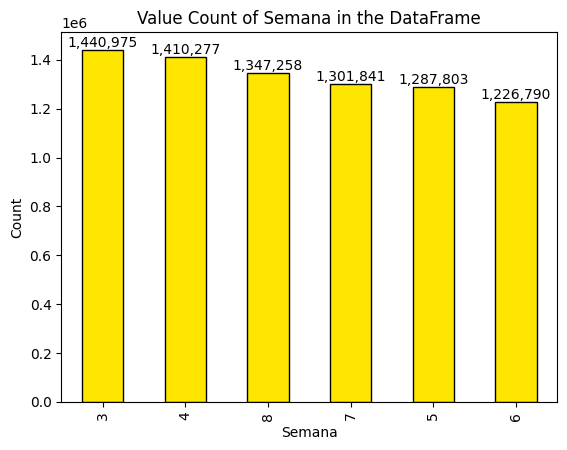

In [25]:
# Define the MercadoLibre brand color
brand_color = "#FFE600"

state_counts = full_candidate_data["Semana"].value_counts()

# Create a bar chart
ax = state_counts.plot(kind='bar', color=brand_color, edgecolor='black')

# Add labels and title
ax.set_xlabel('Semana')
ax.set_ylabel('Count')
ax.set_title('Value Count of Semana in the DataFrame')

# Add annotations (quantity on top of bars)
for i, v in enumerate(state_counts):
    ax.text(i, v + 0.1, '{:,}'.format(v), ha='center', va='bottom')

# Show the plot
plt.show()

There's information realted to 3 different states: Estado de México, México, D.F. and Hidalgo. Being Estado de México the one with more registers.

In [26]:
full_candidate_data.State.value_counts()

ESTADO DE MÉXICO    4430654
MÉXICO, D.F.        3203580
HIDALGO              380710
Name: State, dtype: int64

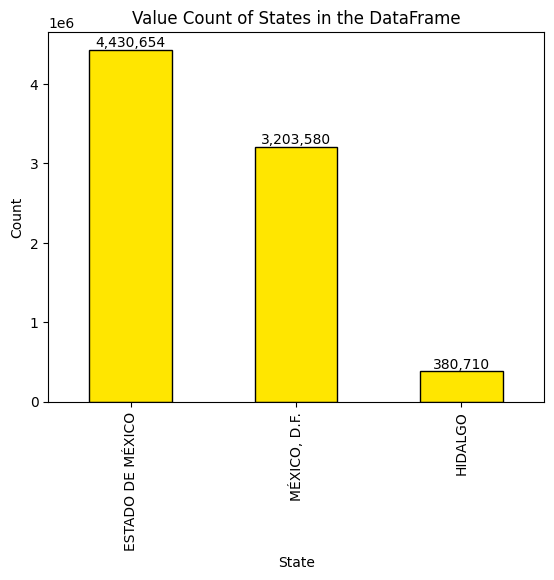

In [27]:
# Define the MercadoLibre brand color
brand_color = "#FFE600"

state_counts = full_candidate_data["State"].value_counts()

# Create a bar chart
ax = state_counts.plot(kind='bar', color=brand_color, edgecolor='black')

# Add labels and title
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('Value Count of States in the DataFrame')

# Add annotations (quantity on top of bars)
for i, v in enumerate(state_counts):
    ax.text(i, v + 0.1, '{:,}'.format(v), ha='center', va='bottom')

# Show the plot
plt.show()

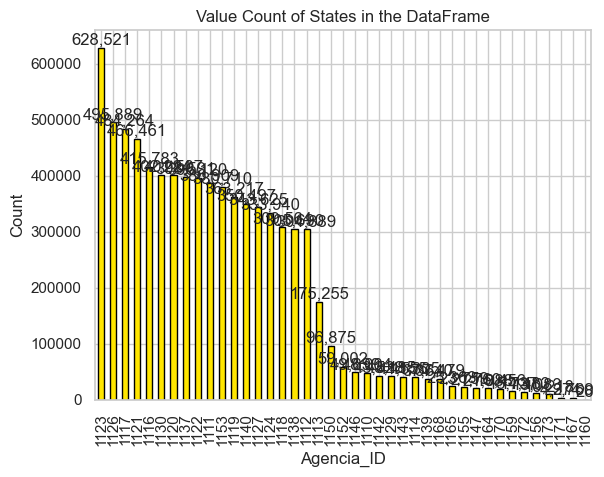

In [84]:
# Define the MercadoLibre brand color
brand_color = "#FFE600"

state_counts = full_candidate_data["Agencia_ID"].value_counts()

# Create a bar chart
ax = state_counts.plot(kind='bar', color=brand_color, edgecolor='black')

# Add labels and title
ax.set_xlabel('Agencia_ID')
ax.set_ylabel('Count')
ax.set_title('Value Count of States in the DataFrame')

# Add annotations (quantity on top of bars)
for i, v in enumerate(state_counts):
    ax.text(i, v + 0.1, '{:,}'.format(v), ha='center', va='bottom')

# Show the plot
plt.show()

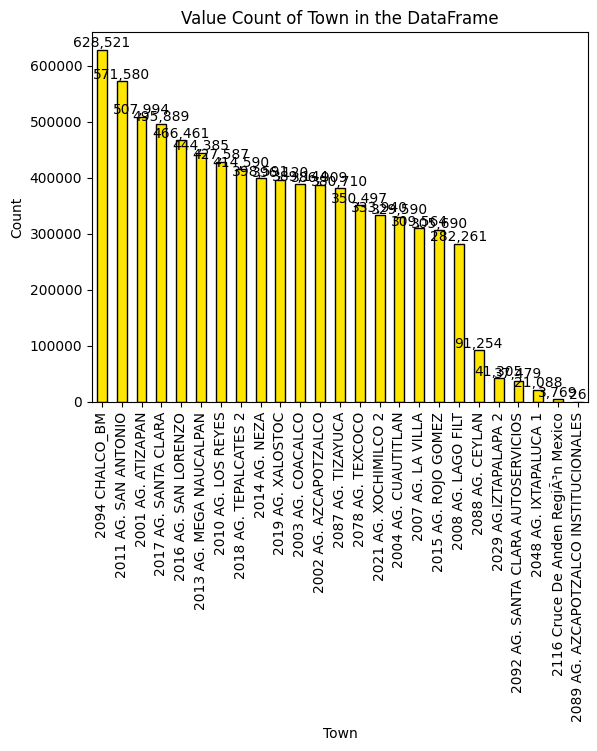

In [37]:
# Define the MercadoLibre brand color
brand_color = "#FFE600"

state_counts = full_candidate_data["Town"].value_counts()

# Create a bar chart
ax = state_counts.plot(kind='bar', color=brand_color, edgecolor='black')

# Add labels and title
ax.set_xlabel('Town')
ax.set_ylabel('Count')
ax.set_title('Value Count of Town in the DataFrame')

# Add annotations (quantity on top of bars)
for i, v in enumerate(state_counts):
    ax.text(i, v + 0.1, '{:,}'.format(v), ha='center', va='bottom')

# Show the plot
plt.show()

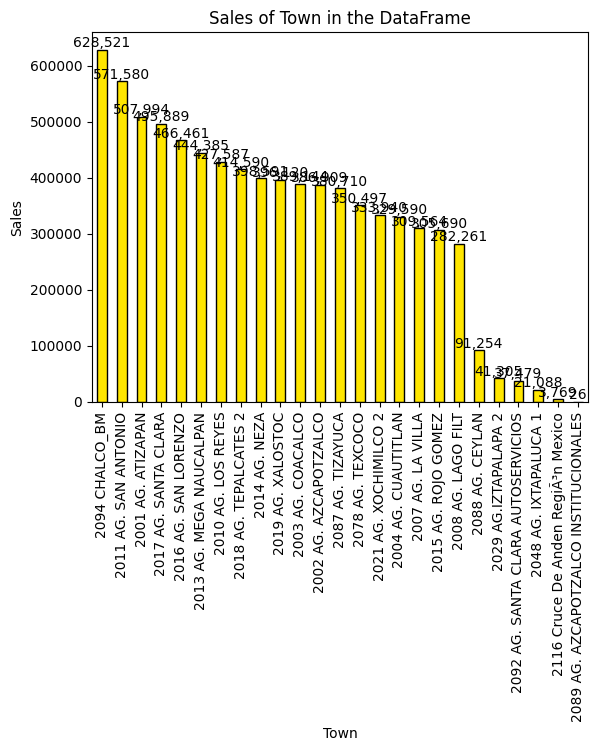

In [46]:
# Define the MercadoLibre brand color
brand_color = "#FFE600"

town_sales = full_candidate_data["Venta_uni_hoy"].sum()

# Create a bar chart
ax = state_counts.plot(kind='bar', color=brand_color, edgecolor='black')

# Add labels and title
ax.set_xlabel('Town')
ax.set_ylabel('Sales')
ax.set_title('Sales of Town in the DataFrame')

# Add annotations (quantity on top of bars)
for i, v in enumerate(state_counts):
    ax.text(i, v + 0.1, '{:,}'.format(v), ha='center', va='bottom')

# Show the plot
plt.show()

As the assessment mention: **"La demanda de un producto en una semana determinada se define como las ventas de esta semana restado por el retorno de la próxima semana."**

Let's check this assumptions is true on data:

By looking for rows where "Dev_uni_proximo" is not 0, we can find that somedays the devs are grather than sells. In those days Demanda is equal to 0.

In [28]:

required_columns = ["Venta_uni_hoy", "Dev_uni_proxima", "Demanda_uni_equil"]
filter = full_candidate_data.loc[full_candidate_data['Dev_uni_proxima'] != 0, required_columns]

print(filter.head(5))


     Venta_uni_hoy  Dev_uni_proxima  Demanda_uni_equil
91               0                2                  0
117              2                1                  1
230              0                2                  0
284              2                1                  1
289              7                1                  6


Let's check the global numbers by week to check that everyting follow the rule:

In [29]:
week_totals = full_candidate_data.pivot_table(values = ["Demanda_uni_equil", "Venta_uni_hoy", "Dev_uni_proxima"],
                                              index = 'Semana', aggfunc = 'sum')
week_totals

,Demanda_uni_equil,Dev_uni_proxima,Venta_uni_hoy
Semana,,,
3,10318145,136118,10415883
4,10557170,133343,10651609
5,9836409,125603,9932558
6,9366322,134062,9461529
7,9834503,155410,9943243
8,10082281,150700,10186415


Ok, there's an important thing to know: **Damanda is calculated as we menssion before, if the devs are grather than sells in the day, the Demanda is 0.** To ensure this is true I will calculate myself Demanda an see if the rule is correct.

In [30]:
full_candidate_data['Calculated_demanda'] = full_candidate_data.apply(
    lambda row: max(row['Venta_uni_hoy'] - row['Dev_uni_proxima'], 0) if row['Dev_uni_proxima'] <= row['Venta_uni_hoy'] else 0,
    axis=1
)

In [31]:
required_columns = ["Venta_uni_hoy", "Dev_uni_proxima", "Demanda_uni_equil", "Calculated_demanda"]
filter = full_candidate_data.loc[full_candidate_data['Dev_uni_proxima'] != 0, required_columns]

print(filter.head(5))

     Venta_uni_hoy  Dev_uni_proxima  Demanda_uni_equil  Calculated_demanda
91               0                2                  0                   0
117              2                1                  1                   1
230              0                2                  0                   0
284              2                1                  1                   1
289              7                1                  6                   6


In [32]:
week_totals = full_candidate_data.pivot_table(values = ["Demanda_uni_equil", "Venta_uni_hoy", "Dev_uni_proxima", "Calculated_demanda"],
                                              index = 'Semana', aggfunc = 'sum')
week_totals

,Calculated_demanda,Demanda_uni_equil,Dev_uni_proxima,Venta_uni_hoy
Semana,,,,
3,10318145,10318145,136118,10415883
4,10557170,10557170,133343,10651609
5,9836409,9836409,125603,9932558
6,9366322,9366322,134062,9461529
7,9834503,9834503,155410,9943243
8,10082281,10082281,150700,10186415


Right, all rows follow that rule. Now we are sure about it.

Ok, now let's drop unnecesary columns, specially those which are just Id columnas:

In [33]:
full_candidate_data.columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Demanda_uni_equil', 'Town', 'State', 'NombreCliente',
       'NombreProducto', 'Calculated_demanda'],
      dtype='object')

In [34]:
full_candidate_data.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreCliente,NombreProducto,Calculated_demanda
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Roles Glass 2p 135g BIM 1216,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Panquecito Gota Choc 2p 140g BIM 1238,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Mantecadas Vainilla 4p 125g BIM 1240,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Donitas Espolvoreadas 6p 105g BIM 1242,3


In [35]:
full_candidate_data_clean = full_candidate_data[["Semana", "Agencia_ID", "Venta_uni_hoy", "Venta_hoy", "Dev_uni_proxima", "Dev_proxima",
                                                 "Demanda_uni_equil", "Town", "State", "NombreCliente", "NombreProducto"]]
full_candidate_data_clean.head()

,Semana,Agencia_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreCliente,NombreProducto
0,3,1110,3,25.14,0,0.0,3,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212
1,3,1110,4,33.52,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Roles Glass 2p 135g BIM 1216
2,3,1110,4,39.32,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Panquecito Gota Choc 2p 140g BIM 1238
3,3,1110,4,33.52,0,0.0,4,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Mantecadas Vainilla 4p 125g BIM 1240
4,3,1110,3,22.92,0,0.0,3,2008 AG. LAGO FILT,"MÉXICO, D.F.",PUESTO DE PERIODICOS LAZARO,Donitas Espolvoreadas 6p 105g BIM 1242


# TASK: Identifiying Agencia to predict:

Ok, now need to take in consideration 2 key aspects to define the Agencia to predict:
1. **Demanda:** Demanda is the most important driver for any desicion-making process. Keeping this in mind We need to have certanty of the top Agencia based on its Demanda. At first sight seem that Agencia_ID 1129,1142 and 1123 are suitable.
2. **Number of registers available.** As we saw in a plot above, the Agencia with more data available is 1123. This is excellent! Also is on top 3 of Agencia with more Demanda.

**In conclusion Agencia_ID 1123 is the one with more data available and the 3rd most important in Demanda so this will be the one selected for the model.**

In [86]:

Agencia_gruped = full_candidate_data_clean.pivot_table(values=["Demanda_uni_equil", "Venta_uni_hoy", "Dev_uni_proxima"],
                                                     index='Agencia_ID', aggfunc={'Demanda_uni_equil': 'sum', 'Venta_uni_hoy': 'sum', 'Dev_uni_proxima': 'sum'})

Agencia_gruped = Agencia_gruped.sort_values(by='Demanda_uni_equil', ascending=False)

Agencia_gruped = Agencia_gruped.assign(Count=full_candidate_data_clean['Agencia_ID'].value_counts())

Agencia_gruped

,Demanda_uni_equil,Dev_uni_proxima,Venta_uni_hoy,Count
Agencia_ID,,,,
1129,3254799,17548,3269823,43185
1142,3012039,32004,3040135,43528
1123,3005332,45951,3037822,628521
1114,2902276,128012,3017499,41305
1121,2825251,24045,2843229,466461
1126,2789773,28969,2812699,495889
1117,2719317,44820,2750388,484264
1116,2630448,31405,2652403,415783
1120,2479288,22368,2495510,401507


Once I decided the **Agencia_ID 1123** is the one I will focus on. Let's create a dataset just for those registers.

In [87]:
agencia_1123_data = full_candidate_data_clean[full_candidate_data_clean["Agencia_ID"] == 1123]
agencia_1123_data.shape

(628521, 11)

In [88]:
agencia_1123_data.head()

,Semana,Agencia_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreCliente,NombreProducto
663350,3,1123,1,15.01,0,0.0,1,2094 CHALCO_BM,ESTADO DE MÉXICO,ROCIO,Pan Blanco Chico 360g BIM 1109
663351,3,1123,2,42.78,0,0.0,2,2094 CHALCO_BM,ESTADO DE MÉXICO,ROCIO,Pan Integral 675g BIM 1146
663352,3,1123,1,19.94,0,0.0,1,2094 CHALCO_BM,ESTADO DE MÉXICO,ROCIO,Pan Blanco 640g BIM 2233
663353,3,1123,3,49.05,0,0.0,3,2094 CHALCO_BM,ESTADO DE MÉXICO,ROCIO,Pan Integral 370g BIM 3631
663354,3,1123,2,28.52,0,0.0,2,2094 CHALCO_BM,ESTADO DE MÉXICO,ROCIO,Totopo Chilaquiles 280g MR 48077


Total Sales from Agencia 1123:

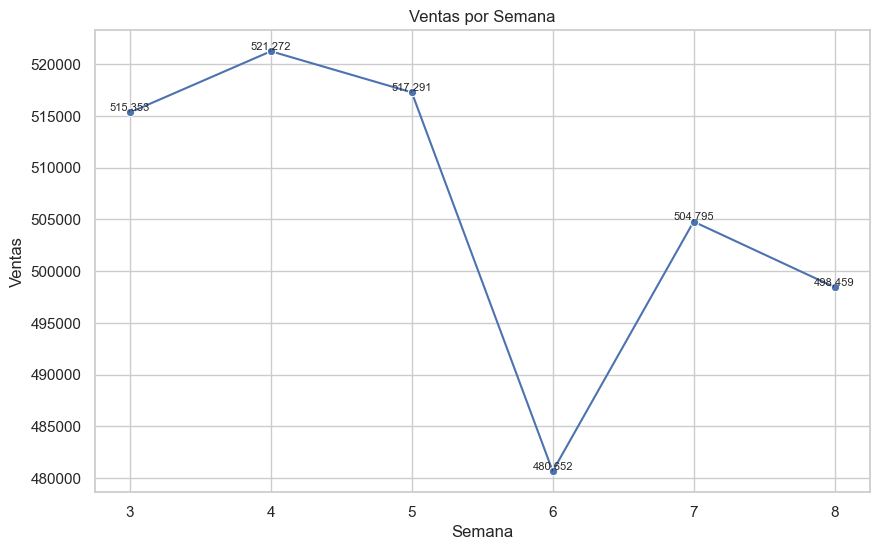

In [90]:


# Agrupar por semana y sumar las ventas en cada semana
df_agrupado = agencia_1123_data.groupby('Semana')['Venta_uni_hoy'].sum().reset_index()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Graficar la serie de tiempo con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Semana', y='Venta_uni_hoy', data=df_agrupado, marker='o', color='b')

# Agregar etiquetas con el valor de cada punto
for index, row in df_agrupado.iterrows():
    plt.text(row['Semana'], row['Venta_uni_hoy'], f'{row["Venta_uni_hoy"]:,.0f}', ha='center', va='bottom', fontsize=8)

plt.title('Ventas por Semana')
plt.xlabel('Semana')
plt.ylabel('Ventas')
plt.show()


Top product form Agencia 1123:

In [91]:
agencia_1123_data.columns

Index(['Semana', 'Agencia_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima',
       'Dev_proxima', 'Demanda_uni_equil', 'Town', 'State', 'NombreCliente',
       'NombreProducto'],
      dtype='object')

In [93]:
agencia_1123_data.Agencia_ID.value_counts()

1123    628521
Name: Agencia_ID, dtype: int64

In [95]:
top_products_agencia_1123 = agencia_1123_data.pivot_table(values=["Venta_uni_hoy"],
                                                     index='NombreProducto', aggfunc= 'sum')

top_products_agencia_1123 = top_products_agencia_1123.sort_values(by='Venta_uni_hoy', ascending=False)
top_products_agencia_1123


,Venta_uni_hoy
NombreProducto,
Nito 1p 62g BIM 1278,341784
Rebanada 2p 55g BIM 1284,264739
Polvoroncitos Panera 40p 16 25g TR 45143,148778
Donas Azucar 4p 105g BIM 1250,127597
Gansito 1p 50g MTB MLA 43285,124836
...,...
Duo Bran Fresa Pina 96g SP BIM 35724,0
Suavicremas Chocolate 158g MTA MLA 34554,0
Galleta Almenuez 57g Tira TR 36001,0


In [98]:
top_cliente_agencia_1123 = agencia_1123_data.pivot_table(values=["Venta_uni_hoy"],
                                                     index='NombreCliente', aggfunc= 'sum')

top_cliente_agencia_1123 = top_cliente_agencia_1123.sort_values(by='Venta_uni_hoy', ascending=False)
top_cliente_agencia_1123

,Venta_uni_hoy
NombreCliente,
NO IDENTIFICADO,483743
LUPITA,34546
MARY 1,33486
MARY,20805
LA VENTANITA,17797
...,...
SACROMONTE,2
ORIENTE,2
ARLETE,2


In [108]:


#Save the top 3 products from San Antonio And then create 3 different datasets to predict
top_3_products = top_products_agencia_1123.index[:3]

datasets_list = [agencia_1123_data[agencia_1123_data["NombreProducto"] == top_3_products[element]] for element in range(len(top_3_products))]

# TASK: Plot specific producto-cliente-agencia

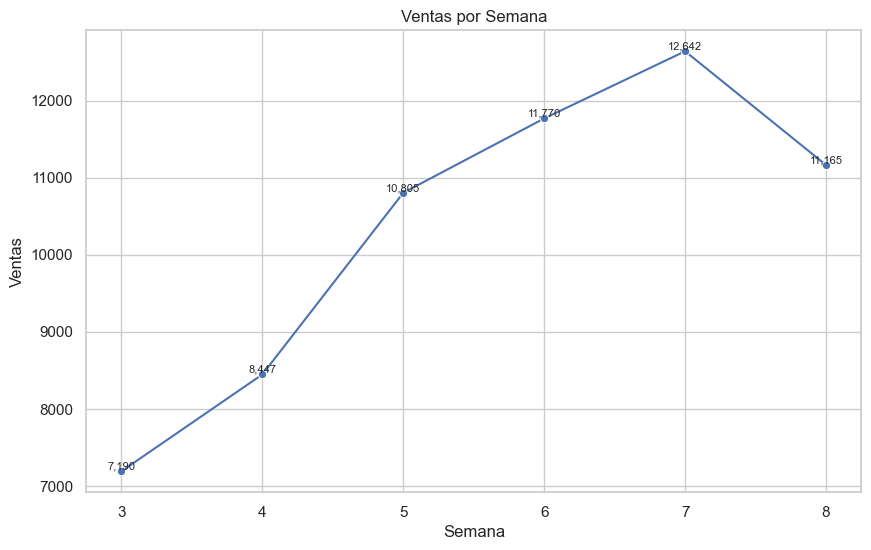

In [109]:
#TASK

#Producto: Nito 1p 62g BIM 1278
#Agencia: 1123
#Cliente: NO IDENTIFICADO

task_data = agencia_1123_data[(agencia_1123_data["NombreProducto"] == 'Nito 1p 62g BIM 1278') & 
                              (agencia_1123_data["NombreCliente"] == 'NO IDENTIFICADO')]



# Agrupar por semana y sumar las ventas en cada semana
df_agrupado = task_data.groupby('Semana')['Venta_uni_hoy'].sum().reset_index()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Graficar la serie de tiempo con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Semana', y='Venta_uni_hoy', data=df_agrupado, marker='o', color='b')

# Agregar etiquetas con el valor de cada punto
for index, row in df_agrupado.iterrows():
    plt.text(row['Semana'], row['Venta_uni_hoy'], f'{row["Venta_uni_hoy"]:,.0f}', ha='center', va='bottom', fontsize=8)

plt.title('Ventas por Semana')
plt.xlabel('Semana')
plt.ylabel('Ventas')
plt.show()


# TASK: Predict the next timme point for 3 top products:

## Product 1.

In [110]:
datasets_list[0]

,Semana,Agencia_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreCliente,NombreProducto
678286,3,1123,10,45.0,0,0.0,10,2094 CHALCO_BM,ESTADO DE MÉXICO,EXPRESS,Nito 1p 62g BIM 1278
678305,3,1123,4,18.0,0,0.0,4,2094 CHALCO_BM,ESTADO DE MÉXICO,JAZMIN,Nito 1p 62g BIM 1278
678328,3,1123,15,67.5,0,0.0,15,2094 CHALCO_BM,ESTADO DE MÉXICO,EMMANUEL,Nito 1p 62g BIM 1278
678349,3,1123,39,175.5,9,40.5,30,2094 CHALCO_BM,ESTADO DE MÉXICO,LUPITA,Nito 1p 62g BIM 1278
678376,3,1123,40,180.0,0,0.0,40,2094 CHALCO_BM,ESTADO DE MÉXICO,EL CARDENAL,Nito 1p 62g BIM 1278
...,...,...,...,...,...,...,...,...,...,...,...
7359667,8,1123,18,81.0,0,0.0,18,2094 CHALCO_BM,ESTADO DE MÉXICO,LA ESCONDIDA,Nito 1p 62g BIM 1278
7359674,8,1123,26,117.0,0,0.0,26,2094 CHALCO_BM,ESTADO DE MÉXICO,RENE,Nito 1p 62g BIM 1278
7359679,8,1123,11,49.5,0,0.0,11,2094 CHALCO_BM,ESTADO DE MÉXICO,ARELI,Nito 1p 62g BIM 1278
7359688,8,1123,19,85.5,0,0.0,19,2094 CHALCO_BM,ESTADO DE MÉXICO,NO IDENTIFICADO,Nito 1p 62g BIM 1278


Some columnas are not longer need it due to low variance, in other words, all the values in the column are exactly the same and this is any informative and don't add any value to the model, let's erase them.

In [111]:
print(datasets_list[0].Agencia_ID.value_counts())
print(datasets_list[0].Town.value_counts())
print(datasets_list[0].State.value_counts())
print(datasets_list[0].NombreProducto.value_counts())


1123    26756
Name: Agencia_ID, dtype: int64
2094 CHALCO_BM    26756
Name: Town, dtype: int64
ESTADO DE MÉXICO    26756
Name: State, dtype: int64
Nito 1p 62g BIM 1278    26756
Name: NombreProducto, dtype: int64


In [132]:
data_product_1 = datasets_list[0].copy()
columns_to_drop = ["Agencia_ID", "Town", "State", "NombreProducto"]
data_product_1.drop(columns_to_drop, axis = 1, inplace = True)

In [133]:
data_product_1

,Semana,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreCliente
678286,3,10,45.0,0,0.0,10,EXPRESS
678305,3,4,18.0,0,0.0,4,JAZMIN
678328,3,15,67.5,0,0.0,15,EMMANUEL
678349,3,39,175.5,9,40.5,30,LUPITA
678376,3,40,180.0,0,0.0,40,EL CARDENAL
...,...,...,...,...,...,...,...
7359667,8,18,81.0,0,0.0,18,LA ESCONDIDA
7359674,8,26,117.0,0,0.0,26,RENE
7359679,8,11,49.5,0,0.0,11,ARELI
7359688,8,19,85.5,0,0.0,19,NO IDENTIFICADO


Mean Squared Error: 0.06433610712301335


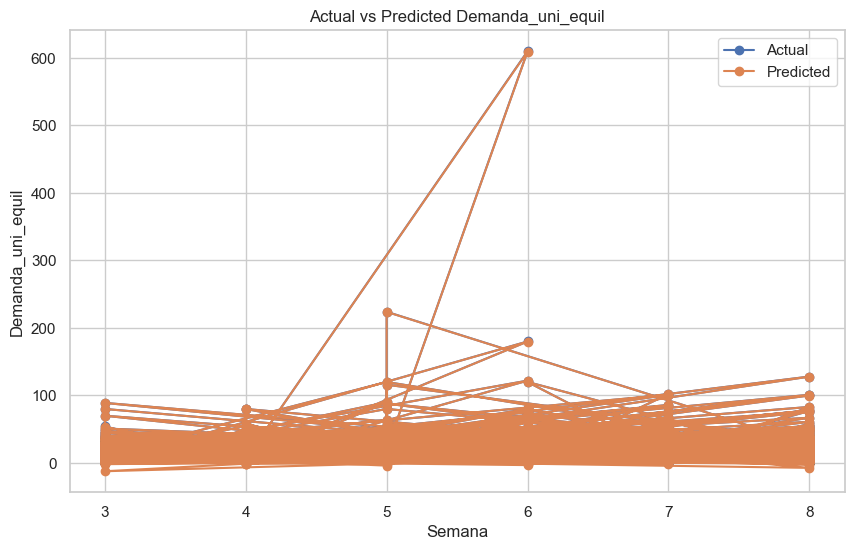

In [134]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'Semana' is the week number
# Set 'Semana' as the index
data_product_1.set_index('Semana', inplace=True)


# Assuming you want to use 'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima' as features
features = ['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima']
X = data_product_1[features]
y = data_product_1['Demanda_uni_equil']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, predictions, label='Predicted', marker='o')
plt.title('Actual vs Predicted Demanda_uni_equil')
plt.xlabel('Semana')
plt.ylabel('Demanda_uni_equil')
plt.legend()
plt.show()

